In [1]:
from twoBodyPINN import *
from SALib.sample import saltelli
from SALib.analyze import sobol
from multiprocessing import Pool
import pandas as pd
import numpy as np
import seaborn as sns
#from os import sched_getaffinity
#from time import time

#ncores = len(sched_getaffinity(0))

Running on CPU



In [2]:
def model(timesteps,depth,width,lr,w1,w2,w3,w4):
        args = {
                "timesteps":int(timesteps),
                "depth":int(depth),
                "width":int(width),
                "lr":lr,
                "weights":[w1,w2,w3,w4],
                "Tmax":4*np.pi,
                "initial":[1,0,0,1.1],
                "epochs":200,
                "seed":2475
               }
        return trainNetwork(**args)[1][-1]
def model_eval(x):
    return model(*x)

In [ ]:
problem = {
    "num_vars":8,
    "names":["timesteps","depth","width","lr","w1",
             "w2","w3","w4"],
    "bounds":[[0.8*514,1.2*514],[0.8*10,1.2*10],[0.8*43,1.2*43],[0.8*0.23,1.2*0.23],[0.8*10.27,1.2*10.27],
              [0.8*0.54,1.2*0.54],[0.8*10.90,1.2*10.90],[0.8*0.00045,1.2*0.00045]]
}

param_values = saltelli.sample(problem,4096,False,skip_values=2*4096)

Y = Pool(ncores).map(model_eval,param_values)

np.save("parameter_values_second_order_2_new.npy",param_values)
np.save("model_results_second_order_2_new.npy",Y)

S = sobol.analyze(problem,Y,calc_second_order=True)

total_Si, first_Si = S.to_df()

Si = pd.concat([total_Si,first_Si],axis=1)

Si.to_csv("Data/SobolSensitivityAnalysis_second_order_2.csv")

In [3]:
results = pd.read_csv("Data/SobolSensitivityAnalysis_second_order_2.csv",index_col=0)
parameter_values = np.load("Data/parameter_values_second_order_2.npy")
model_outputs = np.load("Data/model_results_second_order_2.npy")
df = pd.DataFrame(data=parameter_values)
df["validation"] = model_outputs
df = df.sort_values("validation")

In [4]:
table1 = results.iloc[:8,:-2]
table2 = results.iloc[8:,-2:]
table1 = table1.sort_values("ST",ascending=False)

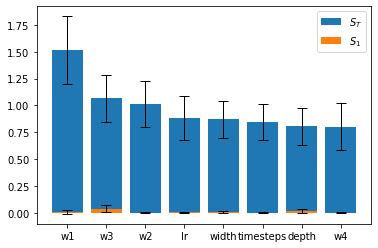

In [5]:
plt.bar(table1.index,table1["ST"],yerr=table1["ST_conf"]/2,capsize=5,ecolor="k",error_kw={"elinewidth":1.},label=r"$S_T$")#,color="green",alpha=1)
plt.bar(table1.index,table1["S1"],yerr=table1["S1_conf"]/2,capsize=5,ecolor="k",error_kw={"elinewidth":1.},label=r"$S_1$")#,color="orange",alpha=1)
plt.legend()

In [6]:
S2 = np.zeros((8,8))
S2[0,1] = table2["S2"][0]
S2[0,2] = table2["S2"][1]
S2[0,3] = table2["S2"][2]
S2[0,4] = table2["S2"][3]
S2[0,5] = table2["S2"][4]
S2[0,6] = table2["S2"][5]
S2[0,7] = table2["S2"][6]
S2[1,2] = table2["S2"][7]
S2[1,3] = table2["S2"][8]
S2[1,4] = table2["S2"][9]
S2[1,5] = table2["S2"][10]
S2[1,6] = table2["S2"][11]
S2[1,7] = table2["S2"][12]
S2[2,3] = table2["S2"][13]
S2[2,4] = table2["S2"][14]
S2[2,5] = table2["S2"][15]
S2[2,6] = table2["S2"][16]
S2[2,7] = table2["S2"][17]
S2[3,4] = table2["S2"][18]
S2[3,5] = table2["S2"][19]
S2[3,6] = table2["S2"][20]
S2[3,7] = table2["S2"][21]
S2[4,5] = table2["S2"][22]
S2[4,6] = table2["S2"][23]
S2[4,7] = table2["S2"][24]
S2[5,6] = table2["S2"][25]
S2[5,7] = table2["S2"][26]
S2[6,7] = table2["S2"][27]

S2[0,0] = table1["S1"][7]
S2[1,1] = table1["S1"][0]
S2[2,2] = table1["S1"][1]
S2[3,3] = table1["S1"][3]
S2[4,4] = table1["S1"][2]
S2[5,5] = table1["S1"][4]
S2[6,6] = table1["S1"][6]
S2[7,7] = table1["S1"][5]

for i in range(8):
    for j in range(i):
        S2[i,j] = S2[j,i]
for i in range(8):
    for j in range(8):
        S2[i,j] = abs(S2[i,j])
names = ["timesteps","depth","width","lr","w1","w2","w3","w4"]
S2 = pd.DataFrame(S2,index=names,columns=names)

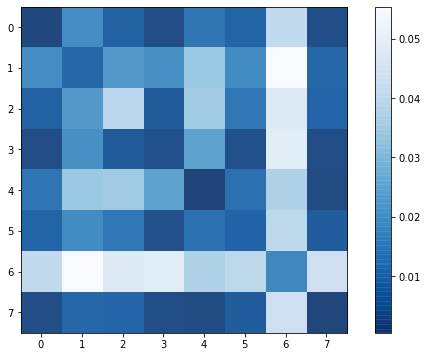

In [7]:
fig = plt.figure(figsize=(10,6))
plt.colorbar(plt.imshow(S2,cmap="Blues_r",alpha=0.9))

In [8]:
params = np.load("Data/parameter_values_second_order_2.npy")
values = np.load("Data/model_results_second_order_2.npy")
indices = values<2e-4 #(74%) #3.165e-5 (10%)
sum(indices), len(values), 100*sum(indices)/len(values)

(54422, 73728, 73.81456163194444)

In [9]:
regParams = params[indices]
regValues = values[indices]

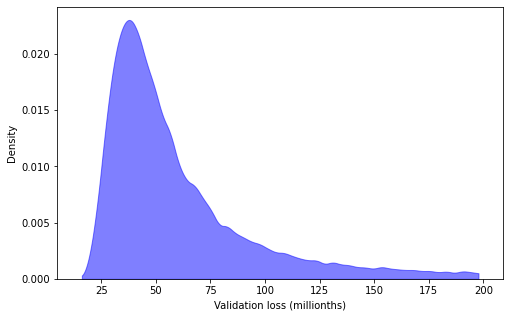

In [10]:
from scipy.interpolate import interp1d

plt.figure(figsize=(8,5))
plt.xlabel("Validation loss (millionths)")
plt.ylabel("Density")
vals,bins,_ = plt.hist(regValues*1e6,bins=50,density=True,alpha=0.)#,color="blue")
bins = 0.5*(bins[1:]+bins[:-1])

inter = interp1d(bins,vals,kind='quadratic',bounds_error=False)
xplot = np.linspace(15,200,500)
plt.fill_between(xplot,inter(xplot),color='b',alpha=0.5)